In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('18100205.csv',header = 0)
#Check out data importing results
print(df.head())

  REF_DATE              GEO           DGUID New housing price indexes  \
0  1981-01           Canada  2016A000011124    Total (house and land)   
1  1981-01           Canada  2016A000011124                House only   
2  1981-01           Canada  2016A000011124                 Land only   
3  1981-01  Atlantic Region      2016A00011    Total (house and land)   
4  1981-01  Atlantic Region      2016A00011                House only   

                 UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID      VECTOR  COORDINATE  \
0  Index, 201612=100     347        units           0  v111955442         1.1   
1  Index, 201612=100     347        units           0  v111955443         1.2   
2  Index, 201612=100     347        units           0  v111955444         1.3   
3  Index, 201612=100     347        units           0  v111955445         2.1   
4  Index, 201612=100     347        units           0  v111955446         2.2   

   VALUE STATUS  SYMBOL  TERMINATED  DECIMALS  
0   38.2    NaN     NaN   

In [6]:
#Check out data types
print(df.dtypes)
#Change REF_DATE into yyyy-mm date type
df['Month'] = pd.to_datetime(df.REF_DATE)

REF_DATE                      object
GEO                           object
DGUID                         object
New housing price indexes     object
UOM                           object
UOM_ID                         int64
SCALAR_FACTOR                 object
SCALAR_ID                      int64
VECTOR                        object
COORDINATE                   float64
VALUE                        float64
STATUS                        object
SYMBOL                       float64
TERMINATED                   float64
DECIMALS                       int64
dtype: object
0   1981-01-01
1   1981-01-01
2   1981-01-01
3   1981-01-01
4   1981-01-01
Name: Month, dtype: datetime64[ns]
datetime64[ns]


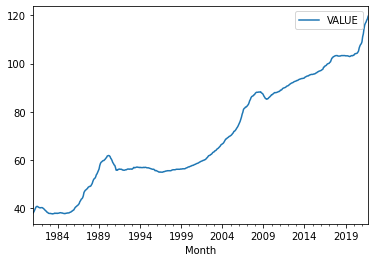

In [9]:
df_Can = df[(df.GEO == "Canada") & (df["New housing price indexes"].str.contains('Total'))]
df_Can.plot(x = 'Month',y = 'VALUE')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Canada new housing price index')
plt.show()